In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import regression_funs as rfu
import funs as fu
import geopandas

import matplotlib.gridspec as gridspec

from sklearn.linear_model import ElasticNetCV

import cartopy.crs as ccrs


# constants

In [2]:

# PATH_TO_FILE = '../data_in/flexpart-mosaic-data_alias/AIRTRACER_100m.nc'

# PATH_TO_SO2 = '../data_in/flexpart-mosaic-data_alias/MSAQSO2L4_2005-2018_v01-04_20190314.h5'

# PATH_TO_ST = '../data_in/ciapitof_masked_filtered.csv'

# PATH_TO_BC = '../data_in/black_carbon_channel6_masked_5min.csv'
# PATH_TO_BC = '../data_in/black_carbon_channel6_raw_5min.csv'

# PATH_TO_SO2 = '../data_in/flexpart-mosaic-data_alias/MSAQSO2L4_2005-2018_v01-04_20190314.h5'

PATH_200_CLUS = '../data_out/cluster1000.nc'

OUT_FILE = '../data_out2/20_SO2_sources_inverse.csv'
OUT_DS_FILE = '../data_out2/DS_20__SO2_sources_inverse.nc'
OUT_CONTRS_FILE = '../data_out2/CONTRS_20__SO2_sources_inverse.csv'

OUT_MEAS_FILE = '../data_out2/MEAS_20__SO2_sources_inverse.csv'


PATH_TO_so2 = '../data_in/so2_concentrations.csv'

SO2 = 'conc_despiked_ppb'


LA = 'lat'
LO = 'lon'
AT = 'AIRTRACER'
L = 'lab'

SA = 'sa'
MSA = 'msa'
IA = 'ia'

BC = 'bc_masked_ngm3'
# BC = 'bc_raw_ngm3'

LBC = 'log(bc)'

LSA = 'log10(sa)'
LMSA = 'log10(msa)'
LIA = 'log10(ia)'

DATA_OUT = '../data_out'

In [3]:
PAR = SO2
#

# open and plot PAR timeseries

In [4]:
def _get_df():
#     df = pd.read_csv(PATH_TO_BC, index_col=0, parse_dates=True)
    df = pd.read_csv(PATH_TO_so2, index_col=0, parse_dates=True)
    zeros = df[PAR] > 0
    print('zeros vs non zeros')
    print(zeros.value_counts())
    df = df[zeros]
    return df

df = _get_df()

zeros vs non zeros
False    325126
True     187712
Name: conc_despiked_ppb, dtype: int64


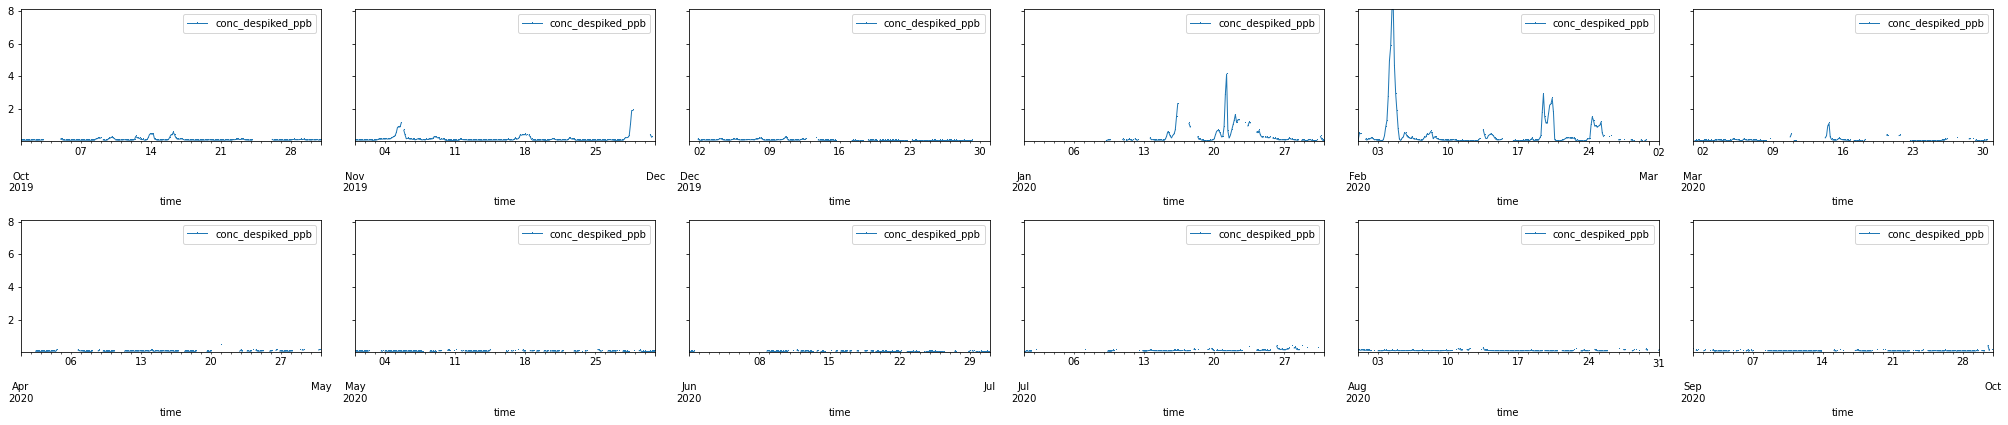

In [5]:
def plt_1(df,ax=None):
    if ax is None:
        f, ax = plt.subplots(figsize=(10, 5))
    df[[PAR]].resample('3H').mean().plot(ax=ax, marker=',', lw=1)
    
def mplt(df):
    qm,qM = df[PAR].quantile([0,.999])
    f,axs = plt.subplots(2,6,sharey=True,figsize=(28,6))
    axf =axs.flatten()
    mm = df.index.min()
    mM = df.index.max()

    ms = [m.strftime('%Y-%m') for m in pd.date_range(mm, mM, freq='M')]
    for i,m in enumerate(ms):
        plt_1(df.loc[m],ax=axf[i])
        ax = axf[i]
        m_ = pd.to_datetime(m)+pd.Timedelta(30,'D')
#         print(m_)
        ax.set_xlim(pd.to_datetime(m), m_)
        ax.set_ylim(qm,qM)
#         ax.set_yscale('symlog',linthresh=1e5,linscale=.1)
#         ax.set_yticks([0,*[a*10**5 for a in range(1,10)],1e5,1e6,1e7])
    f.tight_layout()

mplt(df)

(0.0, 8.917429230769232)

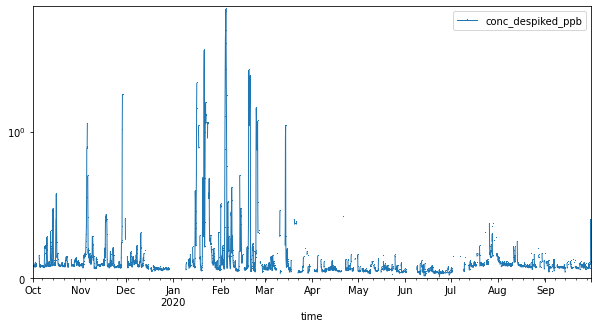

In [6]:
plt_1(df)
plt.gca().set_yscale('symlog',linthresh=1)
plt.gca().set_ylim(0,None)

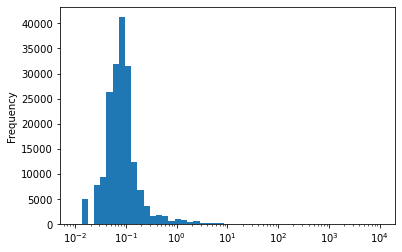

In [7]:
def _plt_dist(df):
    df[PAR].plot.hist(bins=np.geomspace(.01, 10000))
    plt.gca().set_xscale('log')
_plt_dist(df)

# open and merge flex 200 ro 1000 clusters

In [8]:
ds = xr.open_dataset(PATH_200_CLUS)

In [9]:
def _merge_ds_and_df(ds,df):
    dsf = ds.groupby(L).sum().to_dataframe()[AT].unstack(L)

    df1 = df

    df2 = df1.resample('3H').median()

    dm = pd.merge(df2, dsf, left_index=True, right_index=True, how='inner', validate="1:1")
    return dm,dsf 
dm,dsf = _merge_ds_and_df(ds,df)

# 1st CV Inverse modeling elastic NET

0.0008648385874753519 0.1


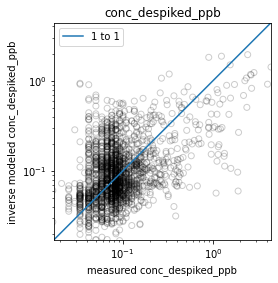

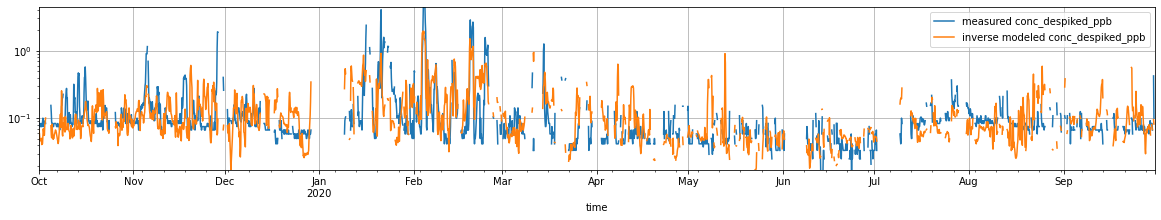

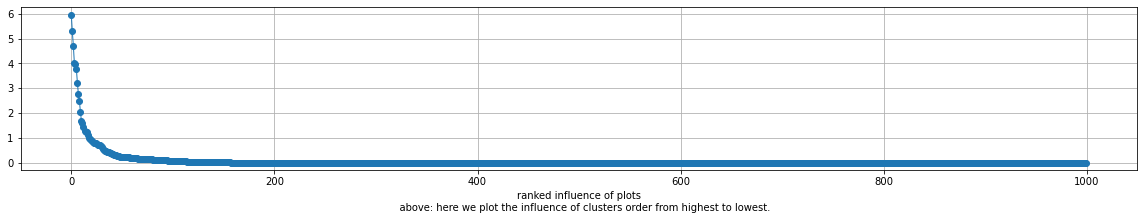

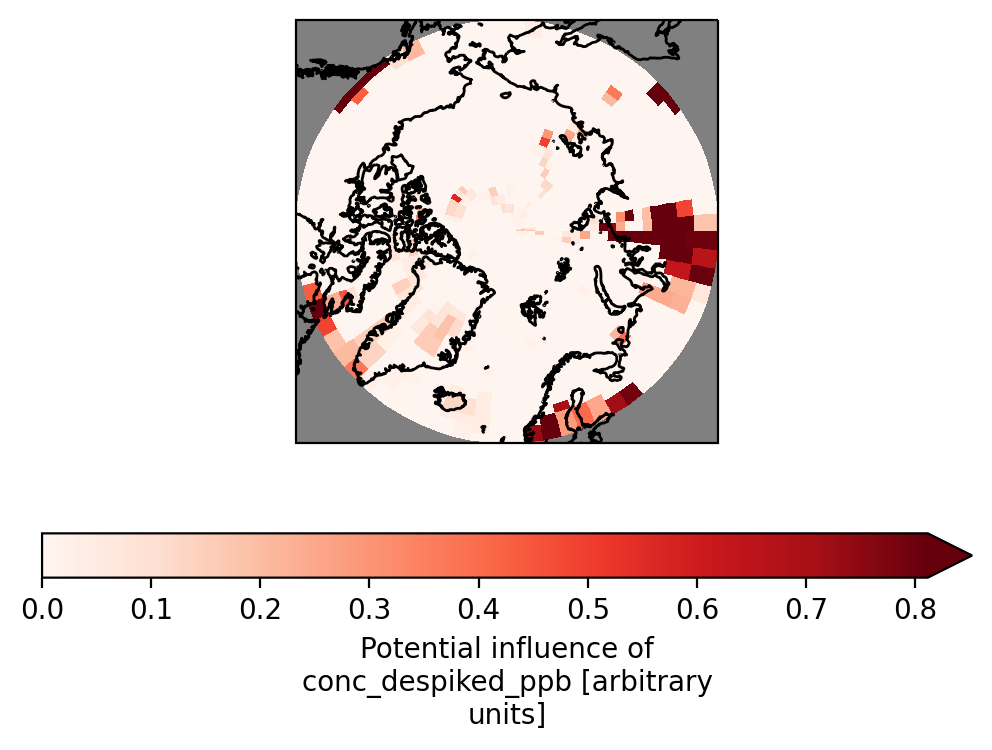

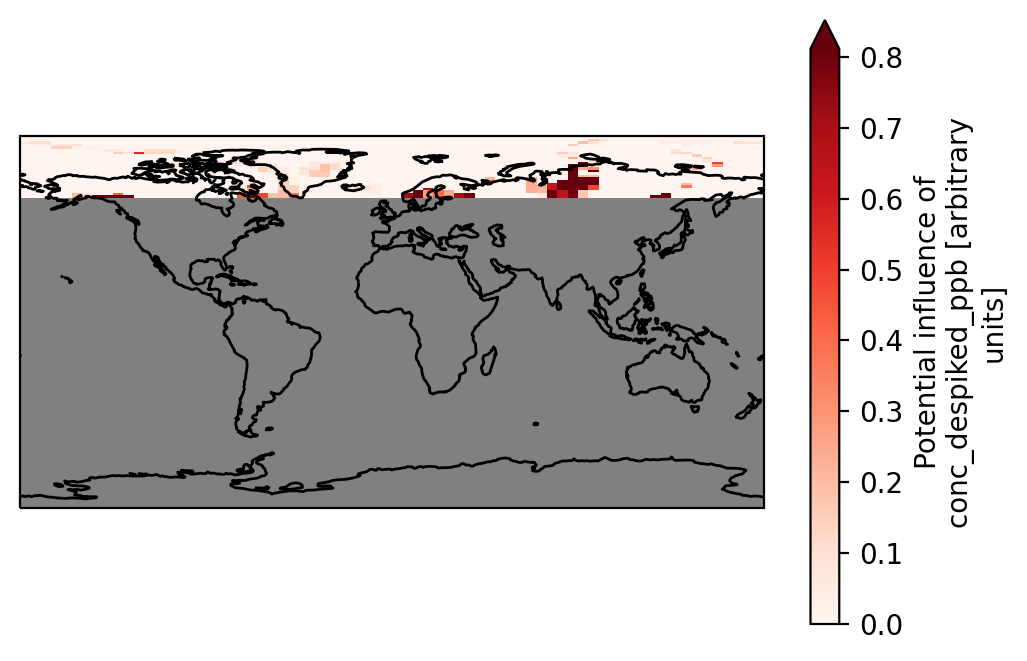

In [10]:
# for PAR in [SA,MSA,IA]:
def plt_el_net(dsf,dm):
    pred, cdf, y, yn, dp, regr = rfu.elastic_net_reg2(dsf, dm, PAR)
    MEA = f'measured {PAR}'
    MOD = f'inverse modeled {PAR}'
    rfu.scatter_plot(y, yn, pred, MEA, MOD, PAR)
    rfu.mea_vs_mod_plot(y, yn, dp, pred, MEA, MOD)
    rfu.rank_cluster_inf(cdf)
    dd2 = rfu.get_plot_inf(cdf, L, ds, PAR)
    rfu.plot_map(dd2)
    rfu.plot_map_rect(dd2)
    return regr

    
regr = plt_el_net(dsf,dm)

In [11]:
pred, cdf, y, yn, dp, regr = rfu.elastic_net_reg2(dsf, dm, PAR)

0.0008648385874753519 0.1


In [12]:
def get_rat(dp,y,yn):
    from sklearn.linear_model import LinearRegression

    lr = LinearRegression(fit_intercept=True).fit(dp[yn].to_frame(),y[yn])
    
    r2 = lr.score(dp[yn].to_frame(),y[yn])
    coef = lr.coef_.item()
    inte = lr.intercept_

    return r2,coef, inte
r2, rat,inte = get_rat(dp,y,yn)
rat, r2,inte

(1.5507575273513794, 0.39956937312691165, -0.05703813)

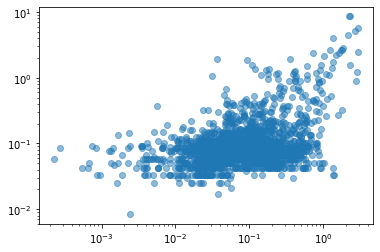

In [13]:
plt.scatter(dp[yn]*rat+inte,y[yn],alpha=.5)
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')

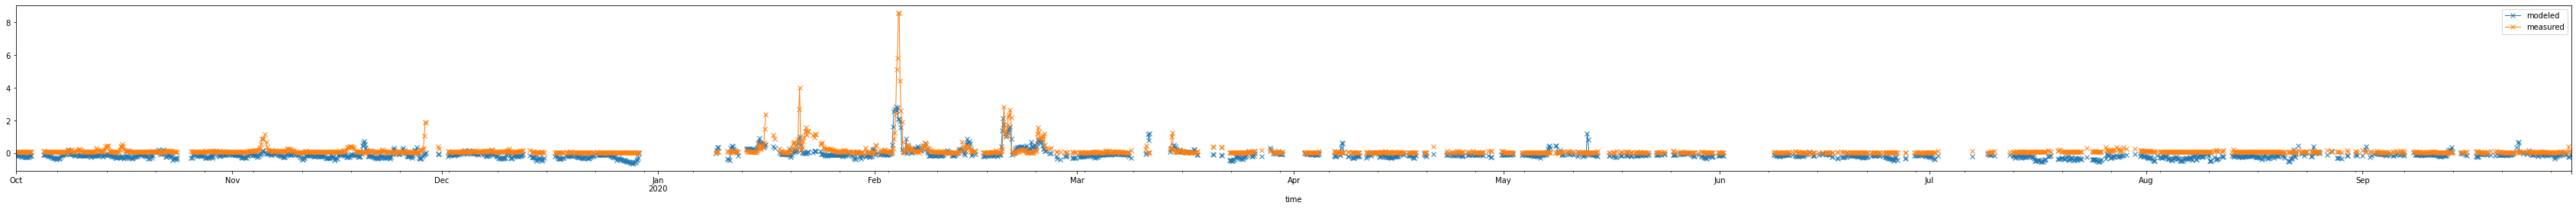

In [14]:
def _plot(rat,dm,dsf,cdf,y, inte):
    # AA = rat #should be 1
    _ = (dm[dsf.columns] * (cdf*rat+inte))
    __ = _.sum(axis=1)[yn].resample('3H').mean()
    __.plot(lw=1,marker='x', label = 'modeled')
    plt.gcf().set_figwidth(60)
#     plt.gca().set_yscale('symlog',linthresh=1e5,linscale=.1)
#     plt.gca().set_ylim(0,None)
    y[yn].resample('3H').mean().plot(lw=1,marker='x', label = 'measured')
    plt.gca().legend()

_plot(rat,dm,dsf,cdf,y,inte)

In [15]:
def get_contr(rat,dm,dsf,cdf,A,yn,inte):
    _cdf = cdf>0
#     AA = rat #should be 1
    _ = (dm[dsf.columns] * (cdf * rat+inte))[yn].T.where(_cdf).T
    __ = _.sum(axis=0)
    a =  __.sort_values()[::-1].cumsum()/__.sum()
    __ = __.where(a<A,0)
    return __

contr =  get_contr(rat,dm,dsf,cdf,1,yn,inte)

In [16]:
contr

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
995    2.055235
996    0.000000
997    2.080107
998    0.000000
999    2.725661
Length: 1000, dtype: float32

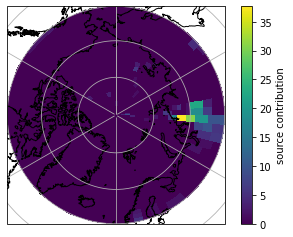

In [17]:
def _plt(ds,contr,ax=None):
    import matplotlib as mpl
    # pred, cdf, y, yn, dp, regr = rfu.elastic_net_reg2(dsf, dm, PAR)

    _1 = ds['lab'].to_dataframe()['lab'].iloc[:, 1].replace(contr.to_dict()).to_xarray()
    _1.name = 'source contribution'

    if ax is None:
        _, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Orthographic(0, 90)))
    ax.coastlines()
    ax.gridlines()
    _1.plot(ax=ax, transform=ccrs.PlateCarree(),vmin=0)


_plt(ds,contr)

In [18]:
N=20

def _clus(dm,dsf,cdf,contr,ds,yn,rat,inte, N ):
#     N = 20

    from sklearn.cluster import KMeans

    contrs_ = (dm[dsf.columns] * (cdf*rat + inte)).T.where(contr > 0, 0).T[yn]

    _norm = np.sqrt((contrs_ ** 2).sum())

    _nn = contrs_ / _norm
    _nn1 = _nn.dropna(axis=1)

    km = KMeans(N, random_state=123)

    _l = km.fit_predict(_nn1.T.values) + 1

    _l1 = pd.Series(_l, index=_nn1.T.index)
    _nl = (_norm * 0 + _l1)

    def _reorder_by_inf(_nl, contrs_):
        i_ = contrs_.T.groupby(_nl).sum().T.sum().sort_values()[::-1].reset_index()['index']
        i_.index = i_.index + 1
        _order = {v: i for i, v in i_.items()}
        _nl = _nl.replace(_order)
        return _nl

    _nl = _reorder_by_inf(_nl, contrs_)

    d_ = ds['lab'].to_series().replace(_nl.to_dict()).to_xarray()
    d_.name = 'sorted_inf_clusters'
    return d_, contrs_, _nl


(
    ds['sorted_inf_clusters'],
    contrs,
    nl
) = _clus(dm,dsf,cdf,contr,ds,yn,rat,inte,N)





In [19]:
a = regr.alpha_
l = regr.l1_ratio_

In [20]:
a,l

(0.0008648385874753519, 0.1)

In [21]:
def _plot_clust_infs(contrs,nl,dsf,cdf,y, rat,dm,inte,yn,N):
    AA = 1
    clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()
    for i in range(1, N+1):
        (AA*clus_ts[i]).plot(c=plt.get_cmap('tab20')(i - 1),lw=5)
    plt.gcf().set_figwidth(60)
    plt.gca().legend()
    #plt.gca().set_yscale('symlog')

    #(contrs.T.groupby(nl).sum().sum()*rat).plot(c='.7', ls='--', marker='D')

    def plt_model(dm):
        _ = dm[dsf.columns] * (cdf * rat + inte)
        __ = _.sum(axis=1)
        __[yn].resample('3H').mean().plot(lw=1, marker='+', label='modeled', alpha=.5, c='k')

    plt_model(dm)

    y[yn].resample('3H').mean().plot(lw=1, marker='o', label='measured', c='k', mfc='none', alpha=.5)

    plt.legend()
    ymin, ymax = y[yn].quantile([0,.999])
#     plt.gca().set_ylim(ymin,ymax)

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_26765/2105437306.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


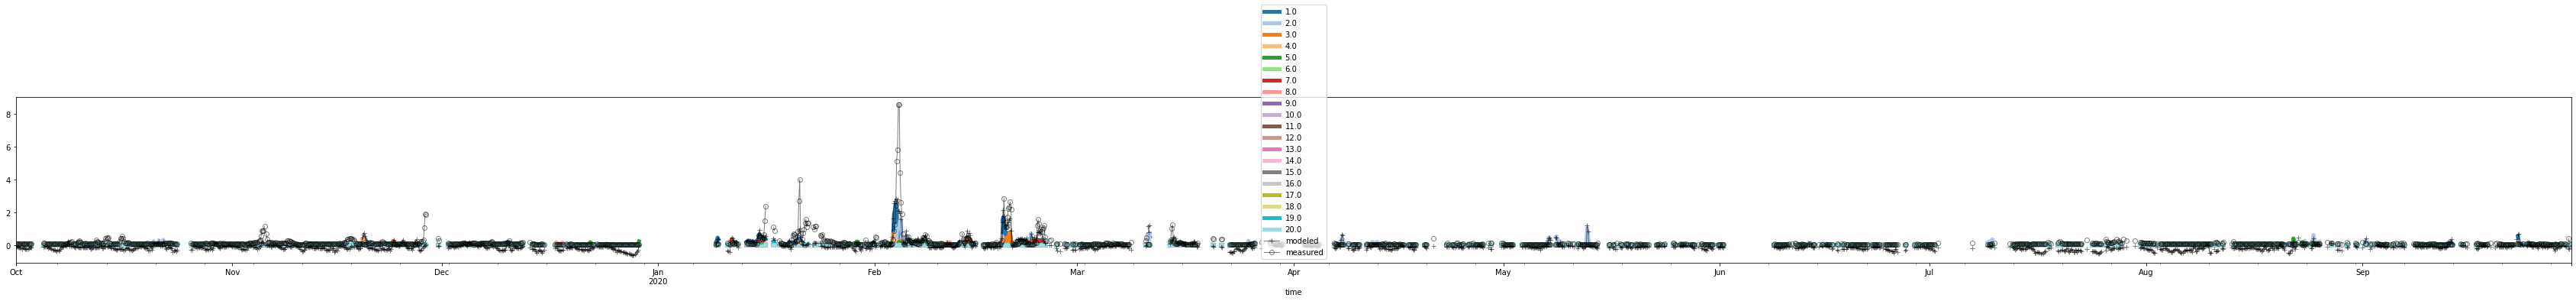

In [22]:
_plot_clust_infs(contrs,nl,dsf,cdf,y, rat, dm,inte,yn,N)

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_26765/3721770567.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


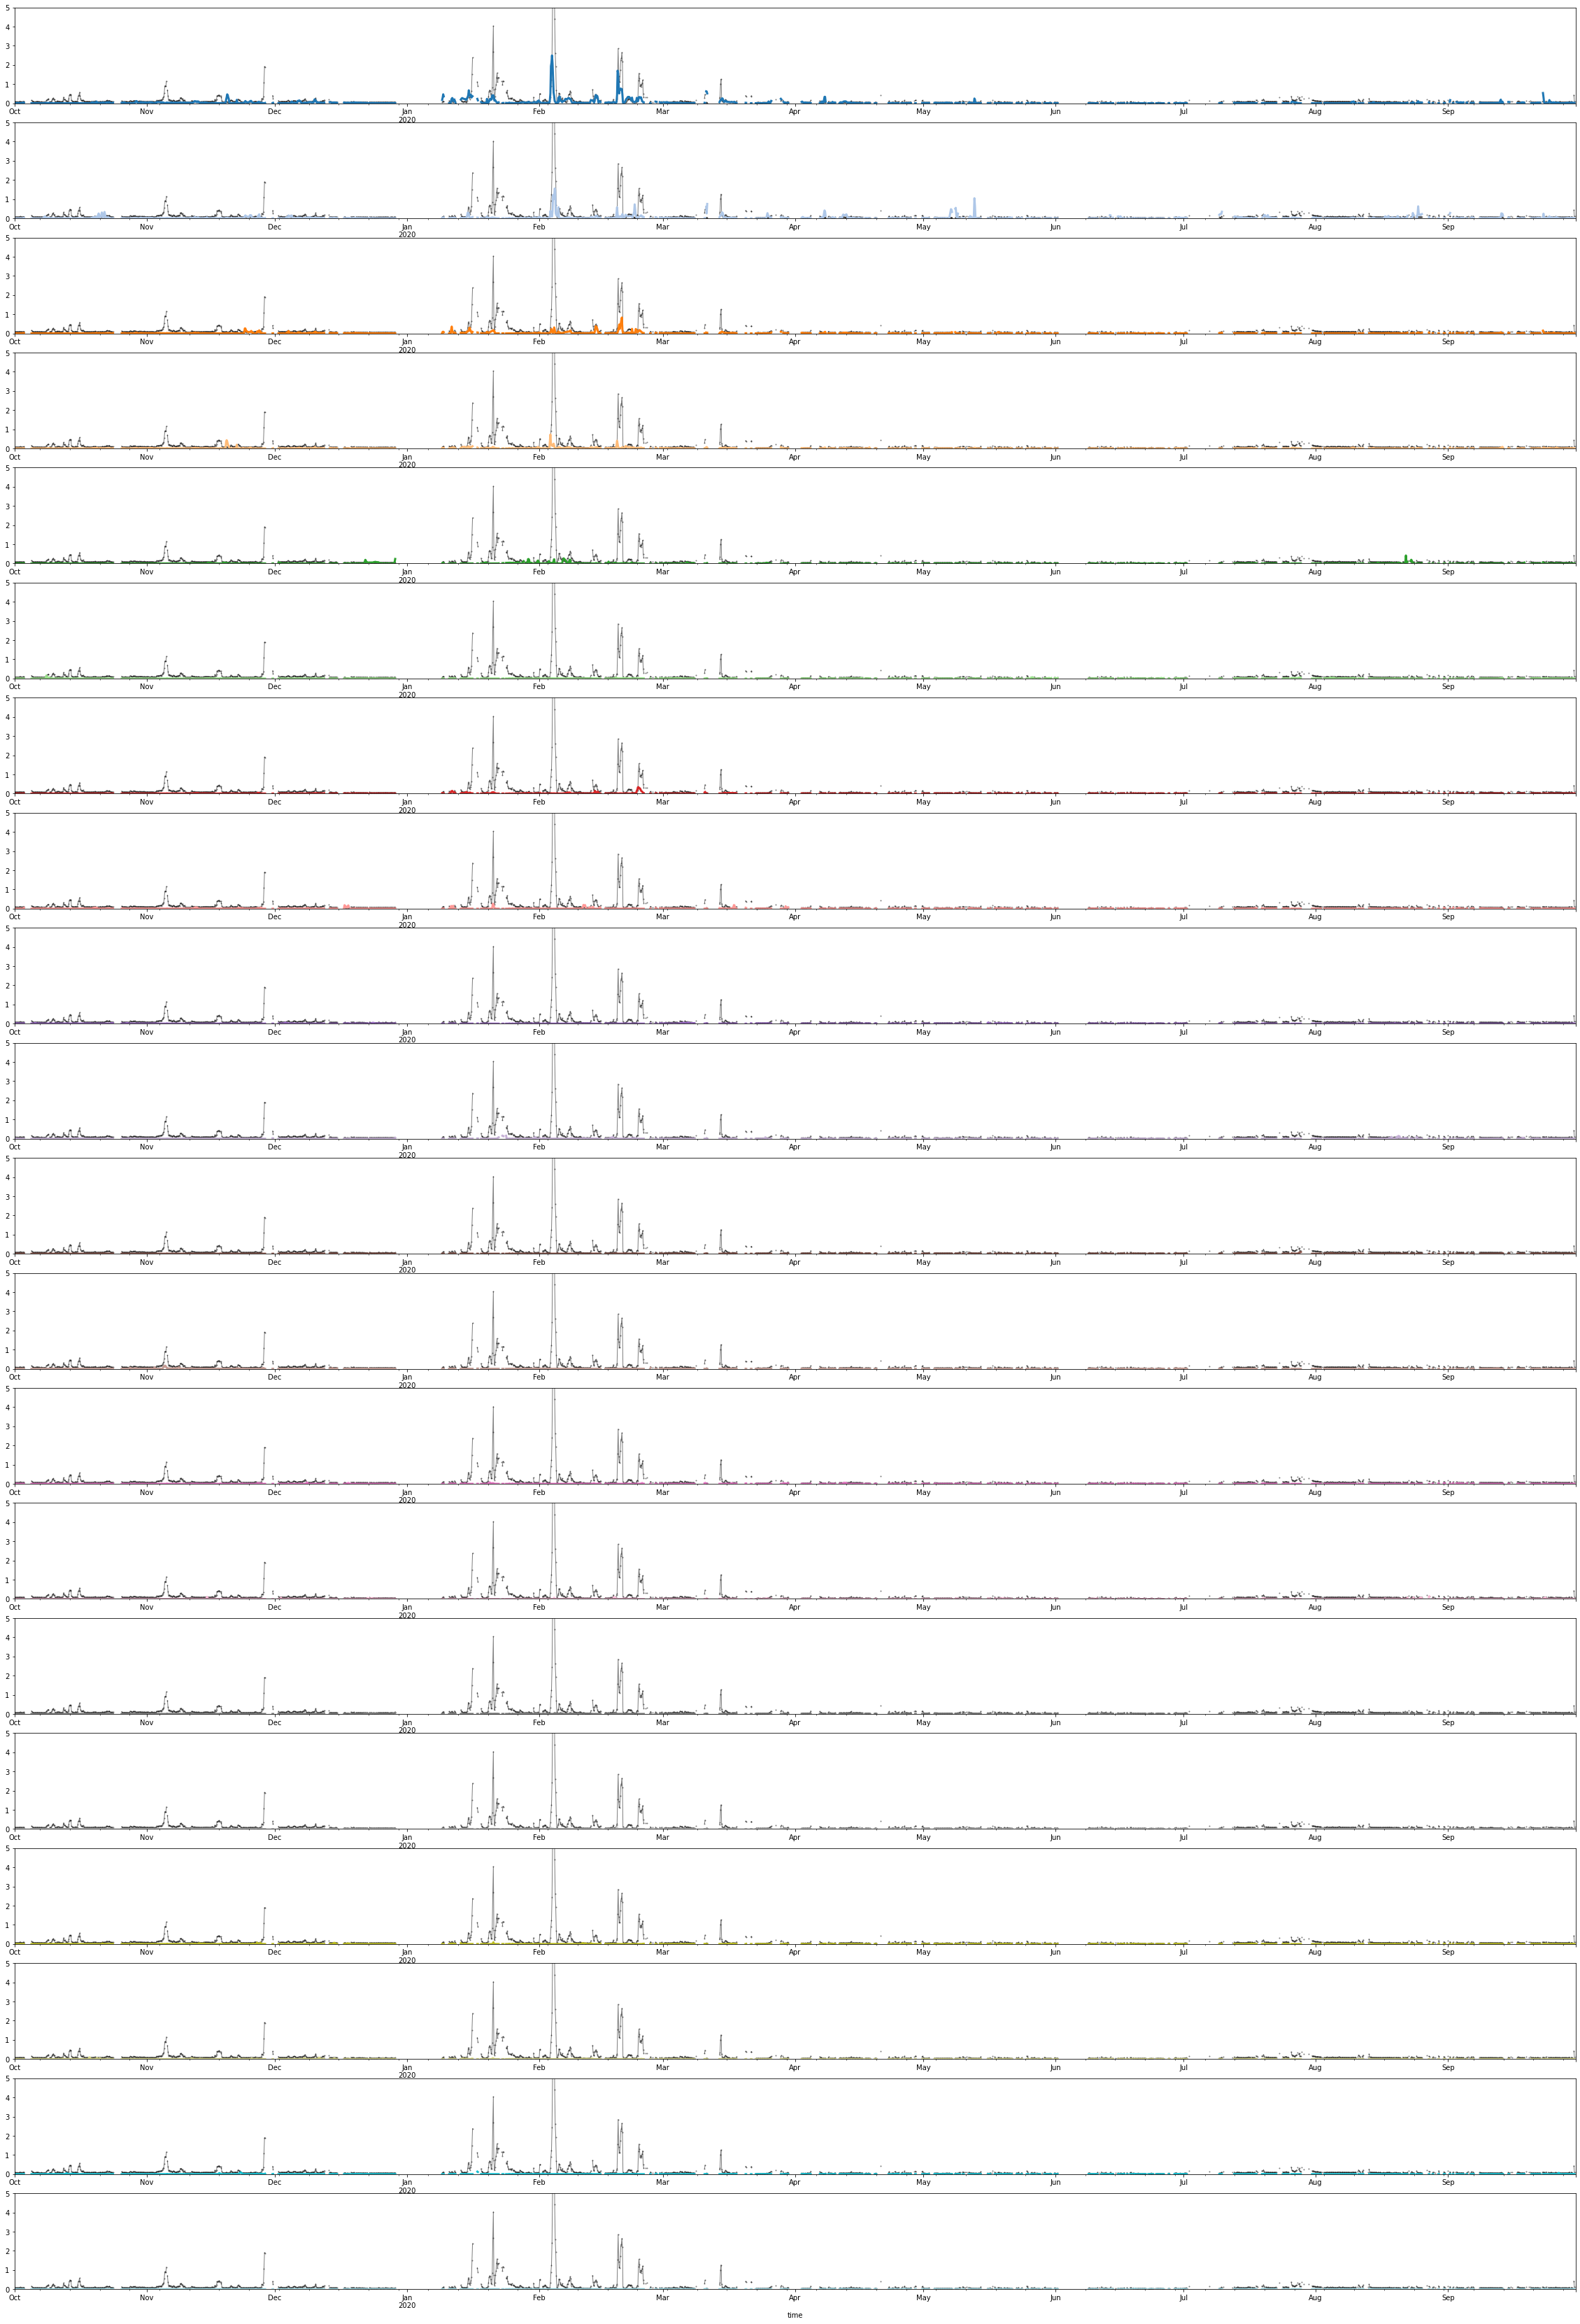

In [23]:
def plot_single_contrs(contrs, nl, yn,y, N):
    clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()
    f, axs = plt.subplots(N, 1, figsize=(40, 3 * 20), sharey=True)
    axf = axs.flatten()
    for i in range(1, N+1):
        y[yn].resample('3H').mean().plot(lw=1, marker='o', label='measured', c='k', mfc='none', alpha=.5, ax=axf[i - 1],
                                         ms=1)
        clus_ts[i].plot(ax=axf[i - 1], c=plt.get_cmap('tab20')(i - 1), lw=3)
        axf[i - 1].set_ylim(0, 5)

plot_single_contrs(contrs, nl, yn,y, N)

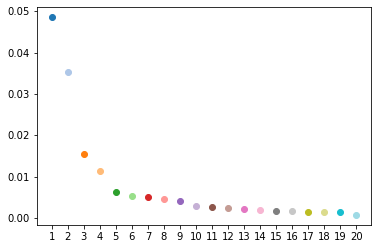

In [24]:
def plt_contrs(contrs,nl,N):
    d = contrs.T.groupby(nl).sum().T.mean()
    for i in range(0,N):
        plt.scatter(d.index[i],d.iloc[i],c=[plt.get_cmap('tab20')(i)])
    plt.gca().set_xticks(range(1,21));
plt_contrs(contrs,nl,N)

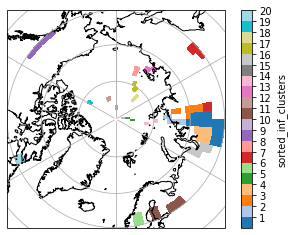

In [25]:
def _plt_influence_clusters(ds):
    import matplotlib as mpl
    _,ax = plt.subplots(subplot_kw=dict(projection=ccrs.Orthographic(0, 90)))
    ax.coastlines()
    ax.gridlines()
    (ds['sorted_inf_clusters']-.5).plot(ax=ax,transform=ccrs.PlateCarree(),cmap='tab20',
                                        cbar_kwargs={'ticks':range(1,21)},
                                        vmin=0,vmax=20)
_plt_influence_clusters(ds)

# multi elastic net

In [26]:
l

0.1

In [27]:
aa = np.geomspace(a/1000,a*10,36)
CC = 31
LL = .1

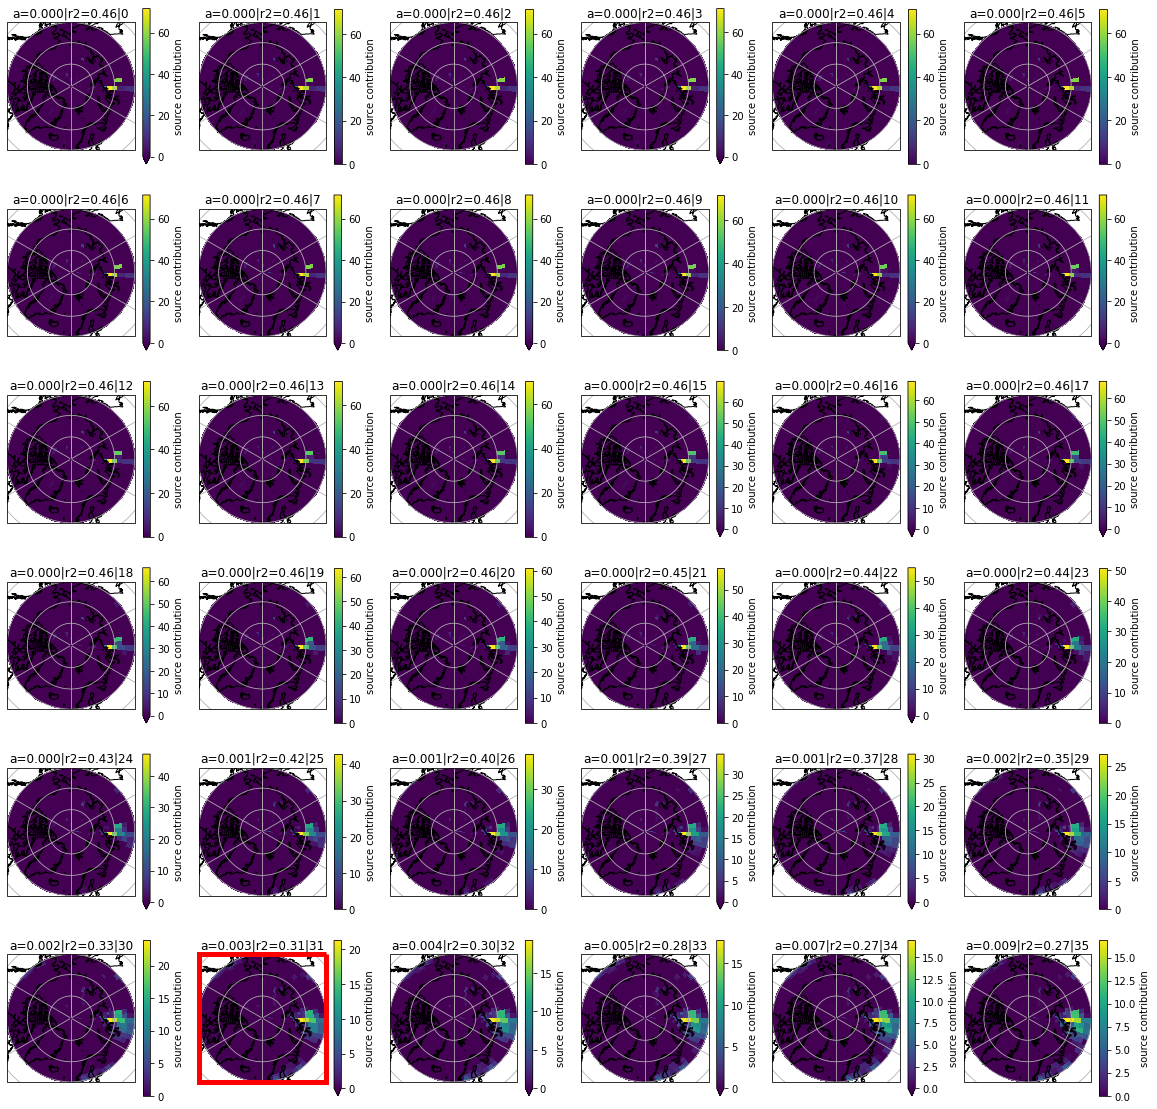

In [28]:
def elastic_net_reg3(dsf, dm, PAR, a, l ):
    from sklearn.linear_model import ElasticNet

    c200 = dsf.columns

    X = dm[c200]

    ### normalize X
    xn = np.sqrt(  (X ** 2).sum()  ) ** (1/1)
    XX = X.divide(xn, axis=1)
    #############


    _y = dm[PAR]
    yn = _y.notna()
    y = _y[yn]
    regr = ElasticNet(a,l1_ratio=l, random_state=123, positive=True, fit_intercept=False)

    regr.fit(XX[yn], y[yn])

#     print(regr.alpha_,regr.l1_ratio_)

    pred = regr.predict(XX[yn])
    dp = pd.Series(pred, index=y[yn].index)
    _cdf = pd.Series(regr.coef_, index=XX.columns)
    cdf = _cdf / xn
    return pred, cdf, y, yn, dp, regr

def _multi_plot(aa,CC):
    
    f,axs = plt.subplots(6,6,figsize=(20,20),subplot_kw=dict(projection=ccrs.Orthographic(0, 90)))
    axf = axs.flatten()
    
    for i_,a_ in enumerate(aa):
        ax = axf[i_]
        pred, cdf, y, yn, dp, regr = elastic_net_reg3(dsf, dm, PAR,a_,LL)
        r2, rat, inte = get_rat(dp,y,yn)
        contr = get_contr(rat,dm,dsf,cdf,1,yn,inte)
        _plt(ds,contr,ax)
        ax.set_title(f'a={a_:.3f}|r2={r2:.2f}|{i_}')
        if i_ == CC:
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(5)
_multi_plot(aa,CC)

# chosen elastic net

In [29]:
pred, cdf, y, yn, dp, regr = elastic_net_reg3(dsf, dm, PAR,aa[CC],LL)
r2, rat, inte = get_rat(dp,y,yn)

In [30]:
LL,aa[CC]

(0.1, 0.003018507099448358)

/Users/aliaga/Documents/Work_DA/Py-packs/flexpart-mosaic/nbV2/regression_funs.py:102: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(q0, q1)
/Users/aliaga/Documents/Work_DA/Py-packs/flexpart-mosaic/nbV2/regression_funs.py:103: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(q0, q1)
/Users/aliaga/Documents/Work_DA/Py-packs/flexpart-mosaic/nbV2/regression_funs.py:118: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(q0, q1)


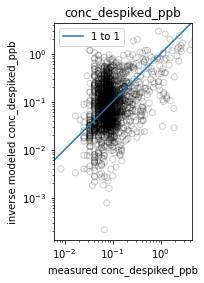

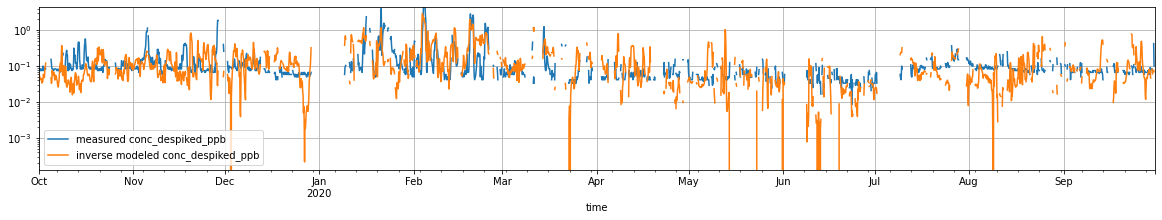

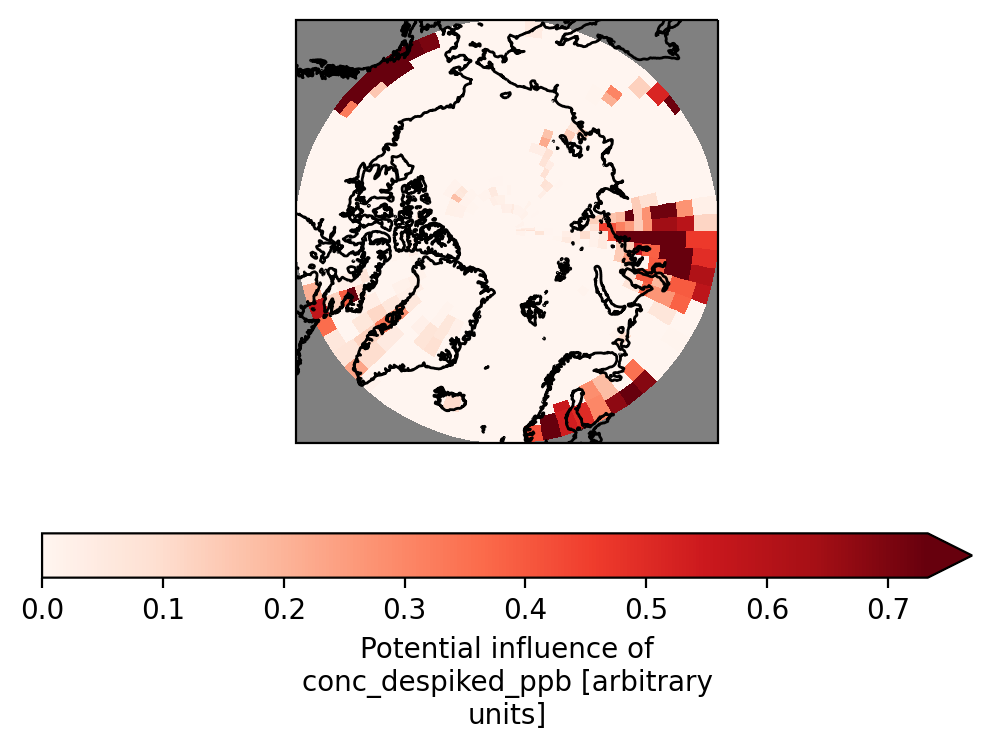

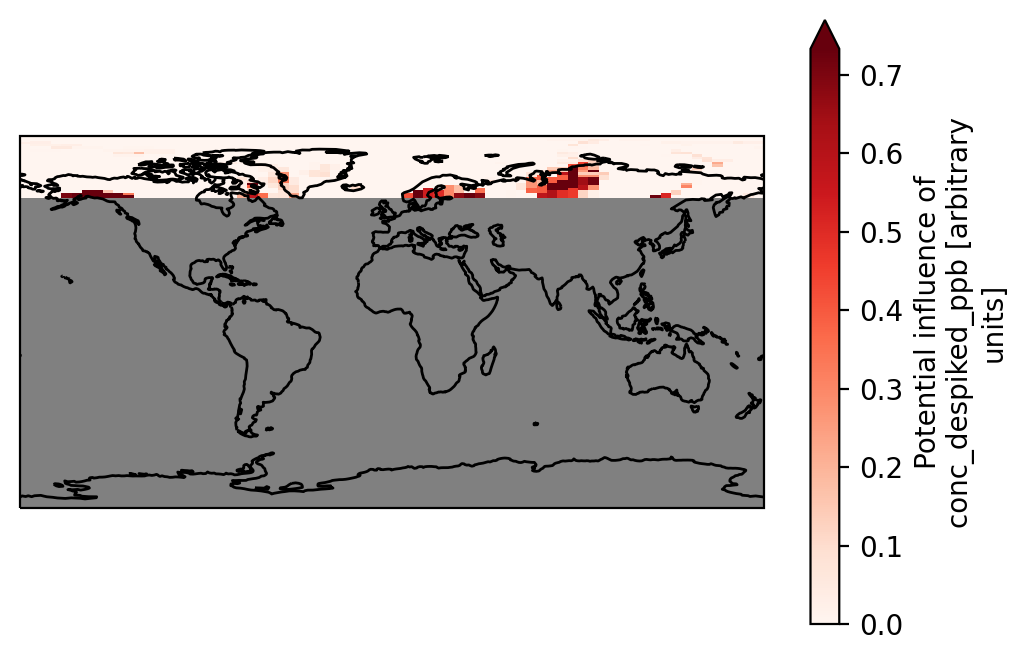

In [31]:
# for PAR in [SA,MSA,IA]:
def plt_el_net():
    
    MEA = f'measured {PAR}'
    MOD = f'inverse modeled {PAR}'
    rfu.scatter_plot(y, yn, pred*rat+inte, MEA, MOD, PAR)
    rfu.mea_vs_mod_plot(y, yn, dp*rat+inte, pred*rat+inte, MEA, MOD)
    #rfu.rank_cluster_inf(cdf)
    dd2 = rfu.get_plot_inf(cdf, L, ds, PAR)
    rfu.plot_map(dd2)
    rfu.plot_map_rect(dd2)
    return regr

    
regr = plt_el_net()

In [32]:
N = 20
contr = get_contr(rat,dm,dsf,cdf,1, yn,inte)

(
    ds['sorted_inf_clusters'],
    contrs,
    nl
) = _clus(dm,dsf,cdf,contr,ds, yn, rat , inte, N)

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_26765/2105437306.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


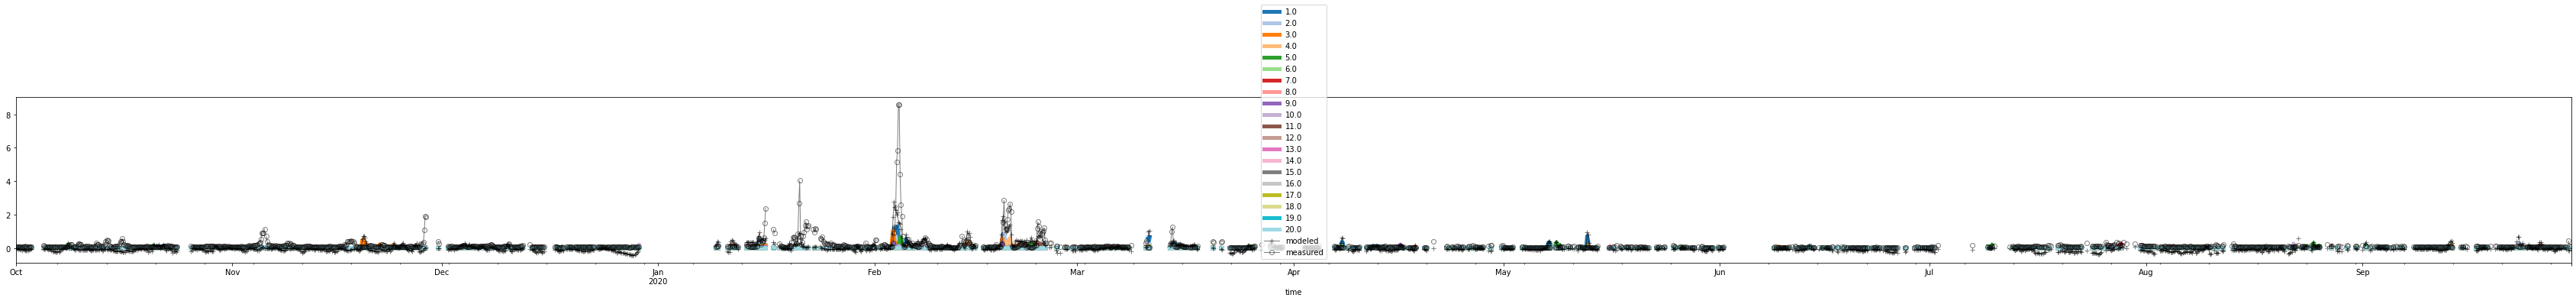

In [33]:
_plot_clust_infs(contrs=contrs,nl=nl,dsf=dsf,cdf=cdf,y=y, rat=rat, dm=dm, inte=inte, yn=yn,N=N)

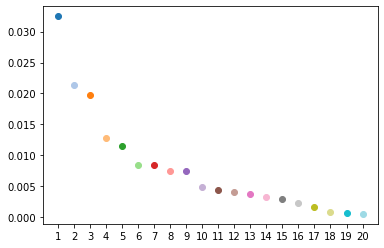

In [34]:
def plt_contrs(contrs,nl):
    d = contrs.T.groupby(nl).sum().T.mean()
    for i in range(0,20):
        plt.scatter(d.index[i],d.iloc[i],c=[plt.get_cmap('tab20')(i)])
    plt.gca().set_xticks(range(1,21));
plt_contrs(contrs,nl)

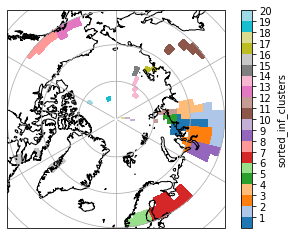

In [35]:
_plt_influence_clusters(ds)

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_26765/3721770567.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


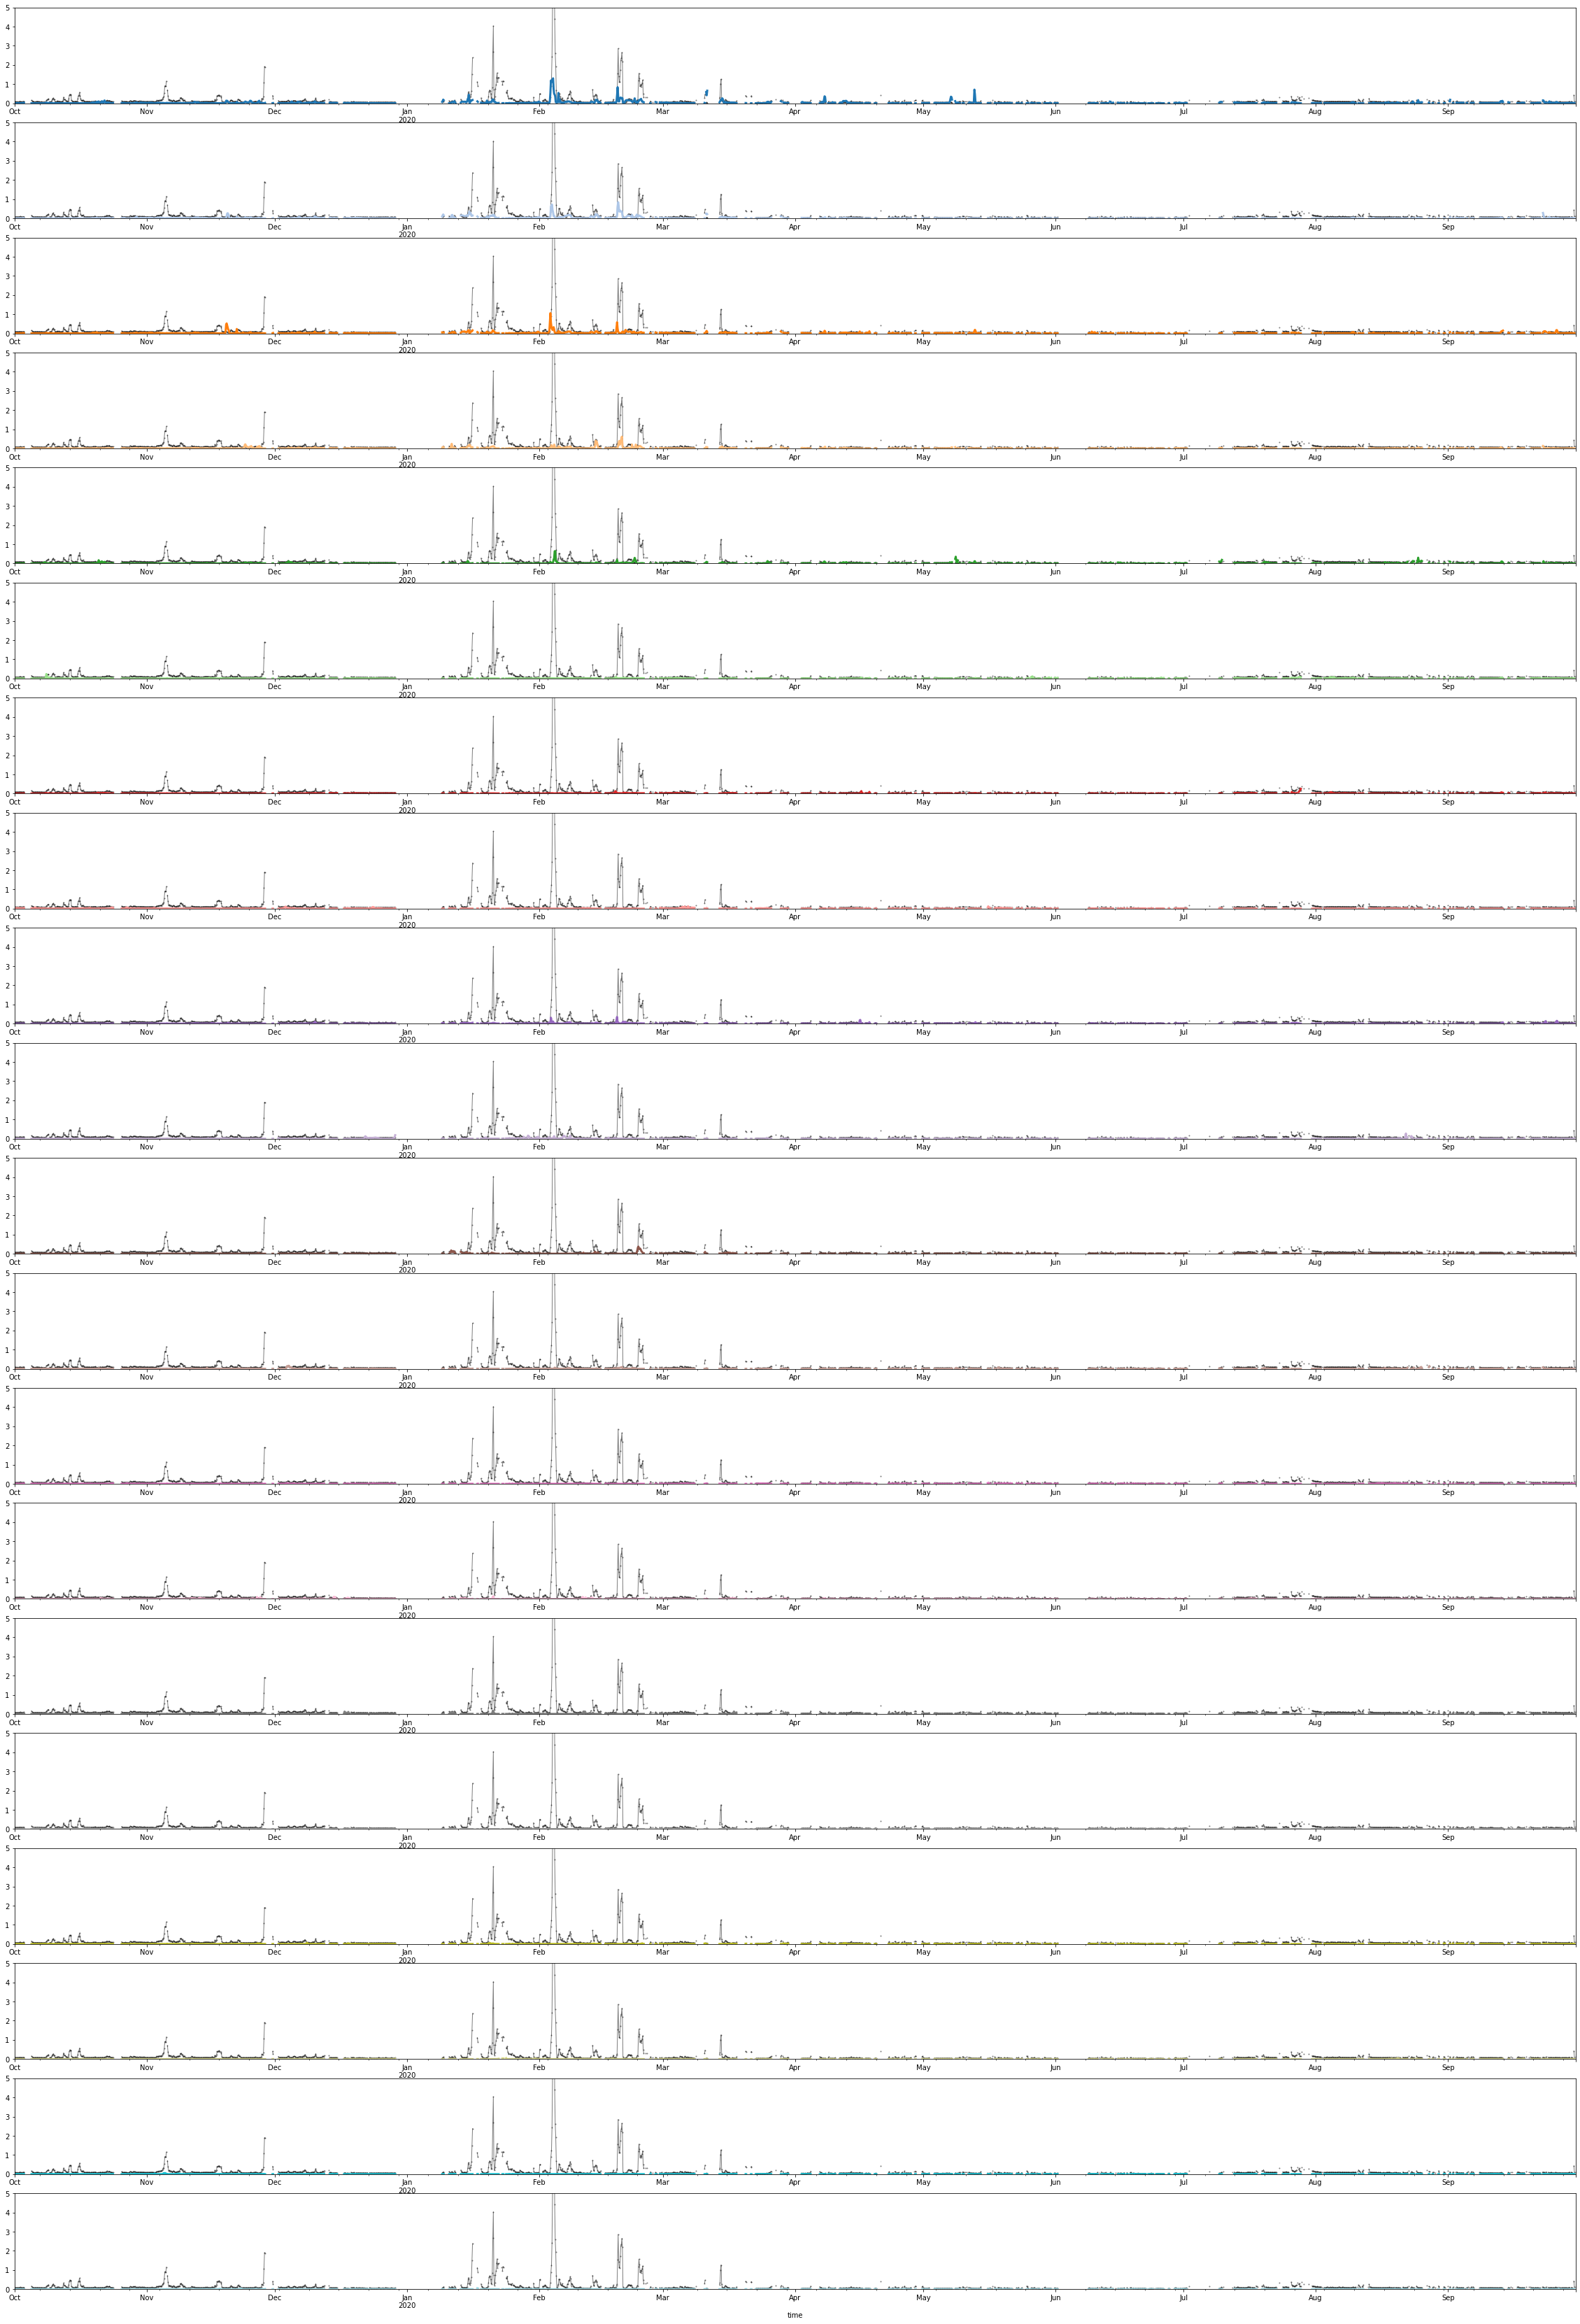

In [36]:
plot_single_contrs(contrs, nl, yn,y,N)

# save data

In [39]:
clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_26765/2478368837.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


In [40]:
clus_ts

1.0       2.0       3.0       4.0       5.0   \
time                                                                    
2019-10-01 00:00:00  0.005084  0.004038  0.002448  0.002269  0.000896   
2019-10-01 03:00:00  0.005174  0.004930  0.003116  0.002210  0.000717   
2019-10-01 06:00:00  0.005320  0.004741  0.003302  0.002072  0.000696   
2019-10-01 09:00:00  0.005632  0.004899  0.003452  0.002228  0.000796   
2019-10-01 12:00:00  0.006399  0.005087  0.003695  0.002123  0.000872   
...                       ...       ...       ...       ...       ...   
2020-09-30 09:00:00       NaN       NaN       NaN       NaN       NaN   
2020-09-30 12:00:00  0.013243  0.011587  0.010525  0.008227  0.003608   
2020-09-30 15:00:00  0.013799  0.011755  0.011570  0.007913  0.003837   
2020-09-30 18:00:00       NaN       NaN       NaN       NaN       NaN   
2020-09-30 21:00:00  0.016457  0.010150  0.011504  0.006829  0.003884   

                         6.0       7.0       8.0       9.0       10.0  \
time                                                                    
2019-10-01 00:00:00  0.005136  0.004363  0.029235  0.001617  0.001422   
2019-10-01 03:00:00  0.005614  0.004650  0.026260  0.001527  0.001407   
2019-10-01 06:00:00  0.006226  0.004638  0.026523  0.001578  0.001298   
2019-10-01 09:00:00  0.005920  0.004628  0.027762  0.001518  0.001193   
2019-10-01 12:00:00  0.005539  0.004276  0.028907  0.001653  0.002742   
...                       ...       ...       ...       ...       ...   
2020-09-30 09:00:00       NaN       NaN       NaN       NaN       NaN   
2020-09-30 12:00:00  0.007370  0.005972  0.011337  0.004340  0.000036   
2020-09-30 15:00:00  0.007187  0.006200  0.010442  0.004971  0.000058   
2020-09-30 18:00:00       NaN       NaN       NaN       NaN       NaN   
2020-09-30 21:00:00  0.006525  0.005878  0.009943  0.004602  0.000053   

                         11.0      12.0      13.0      14.0      15.0  \
time                                                                    
2019-10-01 00:00:00  0.001061  0.000321  0.004479  0.000064  0.000182   
2019-10-01 03:00:00  0.001088  0.000279  0.004116  0.000037  0.000132   
2019-10-01 06:00:00  0.001162  0.000263  0.003813  0.000039  0.000114   
2019-10-01 09:00:00  0.001382  0.000250  0.004027  0.000039  0.000105   
2019-10-01 12:00:00  0.001452  0.000264  0.004388  0.000051  0.000140   
...                       ...       ...       ...       ...       ...   
2020-09-30 09:00:00       NaN       NaN       NaN       NaN       NaN   
2020-09-30 12:00:00  0.000509  0.001165  0.017842  0.000499  0.000853   
2020-09-30 15:00:00  0.000367  0.001007  0.013085  0.000510  0.000709   
2020-09-30 18:00:00       NaN       NaN       NaN       NaN       NaN   
2020-09-30 21:00:00  0.005470  0.000898  0.011656  0.001192  0.001890   

                         16.0      17.0      18.0      19.0      20.0  
time                                                                   
2019-10-01 00:00:00  0.001695  0.009563  0.003506  0.000118  0.000049  
2019-10-01 03:00:00  0.000826  0.006984  0.003902  0.000077  0.000018  
2019-10-01 06:00:00  0.000751  0.005434  0.004061  0.000058  0.000017  
2019-10-01 09:00:00  0.000880  0.004465  0.003116  0.000053  0.000016  
2019-10-01 12:00:00  0.000903  0.004201  0.001598  0.000062  0.000026  
...                       ...       ...       ...       ...       ...  
2020-09-30 09:00:00       NaN       NaN       NaN       NaN       NaN  
2020-09-30 12:00:00  0.000462  0.000570  0.000004  0.000070  0.000303  
2020-09-30 15:00:00  0.000934  0.000371  0.000005  0.000042  0.000391  
2020-09-30 18:00:00       NaN       NaN       NaN       NaN       NaN  
2020-09-30 21:00:00  0.001032  0.001026  0.000007  0.000041  0.001422  

[2928 rows x 20 columns]

In [41]:
clus_ts.to_csv(OUT_FILE)

In [42]:
fu.compressed_netcdf_save(ds,OUT_DS_FILE)

In [43]:
contrs.to_csv(OUT_CONTRS_FILE)

In [44]:
yn.to_csv(OUT_MEAS_FILE)